In [107]:
import re
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde
from deepxde.backend import tf
from scipy.integrate import solve_ivp, odeint
import math
import pandas as pd
from io import StringIO
from scipy.interpolate import interp1d
import torch

# Initial Conditions
T0 = 100000
I0 = 0
L0 = 0
V0 = 200

# Parameters
d = 0.01
beta = 0.0000002
f = 0.001
a = 0.2
delta_I = 1 
delta_L = 0.0039
c = 23
p = 4000
lambda_param = 1000  # T0 * d
Omega = 1

t_initial = 0
t_final = 100

t = np.linspace(t_initial, t_final, 1000)



geom = dde.geometry.TimeDomain(t_initial, t_final)

Y0 = [T0, I0, L0, V0]

def system(Y, t):
    T, I, L, V = Y
    dT_dt = lambda_param - d * T - Omega * beta * V * T
    dI_dt = (1 - f) * Omega * beta * V * T + a * L - delta_I *   I
    dL_dt = f * Omega * beta * V * T - a * L - delta_L * L
    dV_dt = Omega * p * I - c * V
    return [dT_dt, dI_dt, dL_dt, dV_dt]

t = np.linspace(t_initial, t_final, 1000)

solution = odeint(system, Y0, t)
T, I, L, V = solution.T


T_max = np.max(T)
I_max = np.max(I)
L_max = np.max(L)
V_max = np.max(V)

print(f"Upper Bounds:")
print(f"T_max: {T_max}")
print(f"I_max: {I_max}")
print(f"L_max: {L_max}")
print(f"V_max: {V_max}")

# Set the upper bounds with a 10% buffer
ub_T = T_max * 1.1
ub_I = I_max * 1.1 if I_max != 0 else 1.0  # Avoid division by zero
ub_L = L_max * 1.1 if L_max != 0 else 1.0
ub_V = V_max * 1.1

print(f"\nScaled Upper Bounds (with 10% buffer):")
print(f"ub_T: {ub_T}")
print(f"ub_I: {ub_I}")
print(f"ub_L: {ub_L}")
print(f"ub_V: {ub_V}")


Upper Bounds:
T_max: 100000.0
I_max: 34122.40023405826
L_max: 66.74642335613261
V_max: 5929376.922928926

Scaled Upper Bounds (with 10% buffer):
ub_T: 110000.00000000001
ub_I: 37534.64025746409
ub_L: 73.42106569174588
ub_V: 6522314.615221819


In [103]:
interp_T = interp1d(t, T, kind='cubic', fill_value='extrapolate')
interp_I = interp1d(t, I, kind='cubic', fill_value='extrapolate')
interp_L = interp1d(t, L, kind='cubic', fill_value='extrapolate')
interp_V = interp1d(t, V, kind='cubic', fill_value='extrapolate')

# Corrected Function to Ensure Proper Shape
def func(t):
    T_val = interp_T(t)
    I_val = interp_I(t)
    L_val = interp_L(t)
    V_val = interp_V(t)
    return np.column_stack((T_val, I_val, L_val, V_val))





In [104]:
# Define ODE residual
import torch
import deepxde as dde
# ... (keep other imports)

# ... (keep existing code for initial conditions, parameters, and ODE system)

# Define ODE residual
def ode(t, Y):
    T = Y[:, 0:1]
    I = Y[:, 1:2]
    L = Y[:, 2:3]
    V = Y[:, 3:4]
    
    dT_dt = dde.grad.jacobian(Y, t, i=0)
    dI_dt = dde.grad.jacobian(Y, t, i=1)
    dL_dt = dde.grad.jacobian(Y, t, i=2)
    dV_dt = dde.grad.jacobian(Y, t, i=3)
    
    return [
        dT_dt - (lambda_param / ub_T - d * T - Omega * beta * V * ub_V * T),
        dI_dt - ((1 - f) * Omega * beta * V * ub_V * T + a * L * ub_L / ub_I - delta_I * I),
        dL_dt - (f * Omega * beta * V * ub_V * T / ub_L - a * L - delta_L * L),
        dV_dt - (Omega * p * I * ub_I / ub_V - c * V)
    ]





In [105]:
# Define the neural network
net = dde.nn.FNN([1] + [64] * 4 + [4], "tanh", "Glorot normal")

# Define the output modification function to enforce hard initial conditions
def enforce_initial_conditions(t, y):
    t_scaled = (t - t_initial) / (t_final - t_initial)
    return t_scaled * y + torch.tensor([T0 / ub_T, I0 / ub_I, L0 / ub_L, V0 / ub_V])

# Apply the output modification
net.apply_output_transform(enforce_initial_conditions)

# ... (rest of the code remains the same)


In [77]:
model = dde.Model(data, net)

In [78]:
model.compile(
    "adam",
    lr=0.001,
    loss_weights=[1e-6, 1e4, 1e2, 1e-5]  # Only PDE residuals
)

# Train the model
losshistory, train_state = model.train(iterations=20000, display_every=1000)

Compiling model...
'compile' took 0.000369 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.00e+00, 1.49e+03, 1.57e-01, 1.92e+01]    [1.00e+00, 1.49e+03, 1.57e-01, 1.92e+01]    []  
1000      [1.00e+00, 8.94e-05, 2.70e-04, 2.46e-04]    [1.00e+00, 8.90e-05, 2.70e-04, 2.46e-04]    []  
2000      [9.99e-01, 1.57e-05, 4.99e-05, 4.98e-05]    [9.99e-01, 1.56e-05, 4.99e-05, 4.98e-05]    []  
3000      [9.98e-01, 2.09e-05, 3.93e-05, 3.04e-05]    [9.98e-01, 2.09e-05, 3.93e-05, 3.04e-05]    []  
4000      [9.97e-01, 4.63e-06, 1.38e-05, 8.85e-06]    [9.97e-01, 4.64e-06, 1.38e-05, 8.84e-06]    []  
5000      [9.97e-01, 2.01e-06, 7.40e-06, 4.92e-06]    [9.97e-01, 2.01e-06, 7.39e-06, 4.92e-06]    []  
6000      [9.96e-01, 3.07e-05, 4.50e-06, 3.05e-06]    [9.96e-01, 3.07e-05, 4.49e-06, 3.05e-06]    []  
7000      [9.95e-01, 6.06e-06, 3.52e-06, 2.03e-06]    [9.95e-01, 6.03e-06, 3.52e-06, 2.03e-06]    []  
8

KeyboardInterrupt: 

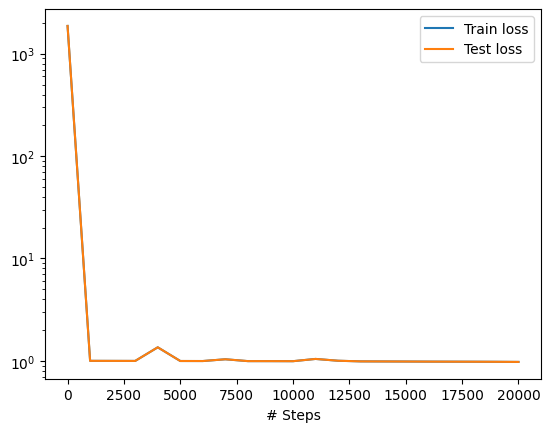

In [73]:
dde.utils.external.plot_loss_history(losshistory)


In [106]:
t_plot = np.linspace(t_initial, t_final, 1000)

PINN_pred = model.predict(t_plot.reshape(-1, 1))

T_pinn = PINN_pred[:, 0]
I_pinn = PINN_pred[:, 1]
L_pinn = PINN_pred[:, 2]
V_pinn = PINN_pred[:, 3]

# Plot PINN Solution
plt.plot(t, np.log10(V_pinn), color="orange", label="log10 V (PINN)")

# Plot ODEint Solution
plt.plot(t, np.log10(V), color="blue", label="log10 V (ODEint)", linestyle='--')

# Adding Labels and Title
plt.xlabel("Time")
plt.ylabel("log10 V")
plt.title("Comparison of PINN and ODEint Solutions")

# Adding Legend
plt.legend()

# Adding Grid
plt.grid(True)

# Display the Plot
plt.show()


#epsilon is 0 until a certain point. epsilon is 0.9 after a certain point, or estimate
#Have data for v for above line

#at point m at end of graph haev L(tm)* 10e6 /(L(tm) + I(tm) + T(tm))

TypeError: 'NoneType' object is not callable

In [12]:
# =======================
# **1. Check and Determine Upper Bounds**
# =======================

# After solving the ODE system, compute and print the maximum values for each variable
T_max = np.max(T)
I_max = np.max(I)
L_max = np.max(L)
V_max = np.max(V)

print(f"Upper Bounds:")
print(f"T_max: {T_max}")
print(f"I_max: {I_max}")
print(f"L_max: {L_max}")
print(f"V_max: {V_max}")

# Optionally, set the upper bounds based on these maxima
ub_T = T_max * 1.1  # Adding 10% buffer
ub_I = I_max * 1.1
ub_L = L_max * 1.1
ub_V = V_max * 1.1

print(f"\nScaled Upper Bounds (with 10% buffer):")
print(f"ub_T: {ub_T}")
print(f"ub_I: {ub_I}")
print(f"ub_L: {ub_L}")
print(f"ub_V: {ub_V}")

Upper Bounds:
T_max: 100000.0
I_max: 34122.40023405826
L_max: 66.74642335613261
V_max: 5929376.922928926

Scaled Upper Bounds (with 10% buffer):
ub_T: 110000.00000000001
ub_I: 37534.64025746409
ub_L: 73.42106569174588
ub_V: 6522314.615221819


In [55]:
# SolvingDEs.ipynb

import re
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde
from deepxde.backend import tf
from scipy.integrate import odeint
import math
import pandas as pd
from io import StringIO
from scipy.interpolate import interp1d

# =======================
# **1. Scaling the Domain and Variables**
# =======================

# Initial Conditions
Y0 = [100000, 0, 0, 200]

# Parameters
d = 0.01
beta = 0.0000002
f = 0.001
a = 0.2
delta_I = 1 
delta_L = 0.0039
c = 23
p = 4000
lambda_param = 1000  # T0 * d
Omega = 1

t_initial = 0
t_final = 100

t = np.linspace(t_initial, t_final, 1000)

# Define ODE system
def system(Y, t):
    T, I, L, V = Y
    dT_dt = lambda_param - d * T - Omega * beta * V * T
    dI_dt = (1 - f) * Omega * beta * V * T + a * L - delta_I * I
    dL_dt = f * Omega * beta * V * T - a * L - delta_L * L
    dV_dt = Omega * p * I - c * V
    return [dT_dt, dI_dt, dL_dt, dV_dt]

# Solve ODE
solution = odeint(system, Y0, t)
T, I, L, V = solution.T

# =======================
# **2. Check and Determine Upper Bounds**
# =======================

# Compute and print the maximum values for each variable
T_max = np.max(T)
I_max = np.max(I)
L_max = np.max(L)
V_max = np.max(V)

print(f"Upper Bounds:")
print(f"T_max: {T_max}")
print(f"I_max: {I_max}")
print(f"L_max: {L_max}")
print(f"V_max: {V_max}")

# Set the upper bounds with a 10% buffer
ub_T = T_max * 1.1
ub_I = I_max * 1.1 if I_max != 0 else 1.0  # Avoid division by zero
ub_L = L_max * 1.1 if L_max != 0 else 1.0
ub_V = V_max * 1.1

print(f"\nScaled Upper Bounds (with 10% buffer):")
print(f"ub_T: {ub_T}")
print(f"ub_I: {ub_I}")
print(f"ub_L: {ub_L}")
print(f"ub_V: {ub_V}")

# Create interpolators for the numerical solution
interp_T = interp1d(t, T, kind='cubic', fill_value='extrapolate')
interp_I = interp1d(t, I, kind='cubic', fill_value='extrapolate')
interp_L = interp1d(t, L, kind='cubic', fill_value='extrapolate')
interp_V = interp1d(t, V, kind='cubic', fill_value='extrapolate')

# Scale solutions
def func_scaled(t_scaled):
    t_true = t_initial + t_scaled * (t_final - t_initial)
    T_val = interp_T(t_true)
    I_val = interp_I(t_true)
    L_val = interp_L(t_true)
    V_val = interp_V(t_true)
    return np.column_stack((
        T_val / ub_T,
        I_val / ub_I,
        L_val / ub_L,
        V_val / ub_V
    ))

# =======================
# **3. Remove Input Transformations Related to Periodicity**
# =======================

# Since periodicity is not required, we use only the time variable as input

def input_transform(t):
    return t  # Identity transform

# =======================
# **4. Apply Output Transformation to Enforce Initial Conditions**
# =======================

def output_transform(t, y):
    T = y[:, 0:1]
    I = y[:, 1:2]
    L = y[:, 2:3]
    V = y[:, 3:4]
    return np.hstack([
        T * np.tanh(t * (t_final - t_initial)) + (Y0[0] / ub_T),
        I * np.tanh(t * (t_final - t_initial)) + (Y0[1] / ub_I),
        L * np.tanh(t * (t_final - t_initial)) + (Y0[2] / ub_L),
        V * np.tanh(t * (t_final - t_initial)) + (Y0[3] / ub_V)
    ], axis=1)

# =======================
# **5. Define the PINN Model**
# =======================

# Define ODE residual
def ode(t, Y):
    T = Y[:, 0:1]
    I = Y[:, 1:2]
    L = Y[:, 2:3]
    V = Y[:, 3:4]
    
    dT_dt = dde.grad.jacobian(Y, t, i=0)
    dI_dt = dde.grad.jacobian(Y, t, i=1)
    dL_dt = dde.grad.jacobian(Y, t, i=2)
    dV_dt = dde.grad.jacobian(Y, t, i=3)
    
    return [
        dT_dt - (lambda_param / ub_T - d * T - Omega * beta * V * T),
        dI_dt - ((1 - f) * Omega * beta * V * T + a * L - delta_I * I) / ub_I,
        dL_dt - (f * Omega * beta * V * T - a * L - delta_L * L) / ub_L,
        dV_dt - (Omega * p * I - c * V) / ub_V
    ]

geom = dde.geometry.TimeDomain(t_initial, t_final)  # Adjusted to actual time range

# Define boundary condition (initial conditions)
def boundary(t, on_initial):
    return on_initial

# Define initial conditions as hard constraints
ic_T = dde.icbc.IC(geom, lambda t: Y0[0] / ub_T, boundary, component=0)
ic_I = dde.icbc.IC(geom, lambda t: Y0[1] / ub_I, boundary, component=1)
ic_L = dde.icbc.IC(geom, lambda t: Y0[2] / ub_L, boundary, component=2)
ic_V = dde.icbc.IC(geom, lambda t: Y0[3] / ub_V, boundary, component=3)

# Define data with balanced loss weights
data = dde.data.PDE(
    geom,
    ode,
    [ic_T, ic_I, ic_L, ic_V],
    num_domain=5000,
    num_boundary=4,  # 4 initial conditions
    solution=func_scaled,
    num_test=1000
)

# Define neural network with optimized architecture
neurons = 64
layers = 4  # Reduced number of hidden layers
activation = "tanh"
initializer = "Glorot normal"

net = dde.nn.FNN([1] + [neurons] * layers + [4], activation, initializer)

# Apply transforms
net.apply_feature_transform(input_transform)
net.apply_output_transform(output_transform)

# Define model
model = dde.Model(data, net)

# =======================
# **6. Adjusting Loss Weights for Multiple Components**
# =======================

# Balanced loss weights
loss_weights = [1.0] * 8  # 4 for PDE residuals and 4 for initial conditions

# Update the model compilation with balanced loss weights
model.compile(
    "adam",
    lr=0.001,
    loss_weights=loss_weights
)

# =======================
# **7. Implementing a Two-Phase Training Strategy**
# =======================

# Phase 1: Train with Adam optimizer
print("Starting Phase 1: Training with Adam optimizer...")
losshistory, train_state = model.train(
    iterations=10000,  # Reduced iterations for Phase 1
    display_every=1000
)

# Phase 2: Train with L-BFGS optimizer
print("\nStarting Phase 2: Training with L-BFGS optimizer...")
model.compile("L-BFGS")
losshistory, train_state = model.train()

# =======================
# **8. Plotting Loss History**
# =======================

dde.utils.external.plot_loss_history(losshistory)
plt.show()

# =======================
# **9. Making Predictions**
# =======================

# Predict scaled solutions
Y_pinn_scaled = model.predict(t.reshape(-1, 1))

# Denormalize predictions
Y_pinn = Y_pinn_scaled * np.array([ub_T, ub_I, ub_L, ub_V])

# =======================
# **10. Comparing with Numerical Solution**
# =======================

variables = ['T', 'I', 'L', 'V']
for i, var in enumerate(variables):
    plt.figure(figsize=(10, 6))
    plt.plot(t, Y_pinn[:, i], label=f"{var} (PINN)")
    plt.plot(t, solution[:, i], label=f"{var} (ODEint)", linestyle='--')
    plt.xlabel("Time")
    plt.ylabel(var)
    plt.title(f"Comparison of PINN and ODEint Solutions for {var}(t)")
    plt.legend()
    plt.grid(True)
    plt.show()

# =======================
# **End of Script**
# =======================

Upper Bounds:
T_max: 100000.0
I_max: 34122.40023405826
L_max: 66.74642335613261
V_max: 5929376.922928926

Scaled Upper Bounds (with 10% buffer):
ub_T: 110000.00000000001
ub_I: 37534.64025746409
ub_L: 73.42106569174588
ub_V: 6522314.615221819
Compiling model...
'compile' took 0.000126 s



Starting Phase 1: Training with Adam optimizer...
Training model...



RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [99]:
# In[0]: Import necessary libraries and set initial parameters

import re
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde
from deepxde.backend import tf
from scipy.integrate import odeint
import math
import pandas as pd
from io import StringIO
from scipy.interpolate import interp1d
import torch

# =======================
# **1. Define Initial Conditions and Parameters**
# =======================

# Initial Conditions
Y0 = [100000, 0, 0, 200]  # [T0, I0, L0, V0]

# Parameters
d = 0.01
beta = 0.0000002
f = 0.001
a = 0.2
delta_I = 1 
delta_L = 0.0039
c = 23
p = 4000
lambda_param = 1000  # T0 * d
Omega = 1

t_initial = 0
t_final = 400  # Expanded from 100 to 400 to cover ~1 year

t = np.linspace(t_initial, t_final, 2000)  # Increased number of points for higher resolution

# =======================
# **2. Define ODE System**
# =======================

def system(Y, t):
    T, I, L, V = Y
    dT_dt = lambda_param - d * T - Omega * beta * V * T
    dI_dt = (1 - f) * Omega * beta * V * T + a * L - delta_I * I
    dL_dt = f * Omega * beta * V * T - a * L - delta_L * L
    dV_dt = Omega * p * I - c * V
    return [dT_dt, dI_dt, dL_dt, dV_dt]

# =======================
# **3. Solve ODE Numerically**
# =======================

solution = odeint(system, Y0, t)
T, I, L, V = solution.T

# =======================
# **4. Compute and Print Maximum Values**
# =======================

T_max = np.max(T)
I_max = np.max(I)
L_max = np.max(L)
V_max = np.max(V)

print(f"Maximum Values:")
print(f"T_max: {T_max}")
print(f"I_max: {I_max}")
print(f"L_max: {L_max}")
print(f"V_max: {V_max}")

# =======================
# **5. Create Interpolators for Numerical Solutions**
# =======================

interp_T = interp1d(t, T, kind='cubic', fill_value='extrapolate')
interp_I = interp1d(t, I, kind='cubic', fill_value='extrapolate')
interp_L = interp1d(t, L, kind='cubic', fill_value='extrapolate')
interp_V = interp1d(t, V, kind='cubic', fill_value='extrapolate')

# =======================
# **6. Define Function for Solutions**
# =======================

def func(t_input):
    """Function to provide the exact solution for training and testing."""
    T_val = interp_T(t_input)
    I_val = interp_I(t_input)
    L_val = interp_L(t_input)
    V_val = interp_V(t_input)
    return np.column_stack((T_val, I_val, L_val, V_val))

Maximum Values:
T_max: 100000.0
I_max: 34125.54548242535
L_max: 66.72011290826265
V_max: 5928964.0515506575


In [100]:
# In[1]: Define ODE Residual Without Scaling

import torch
import deepxde as dde

# Define ODE residual
def ode(t, Y):
    T = Y[:, 0:1]
    I = Y[:, 1:2]
    L = Y[:, 2:3]
    V = Y[:, 3:4]
    
    dT_dt = dde.grad.jacobian(Y, t, i=0)
    dI_dt = dde.grad.jacobian(Y, t, i=1)
    dL_dt = dde.grad.jacobian(Y, t, i=2)
    dV_dt = dde.grad.jacobian(Y, t, i=3)
    
    return [
        dT_dt - (lambda_param - d * T - Omega * beta * V * T),
        dI_dt - ((1 - f) * Omega * beta * V * T + a * L - delta_I * I),
        dL_dt - (f * Omega * beta * V * T - a * L - delta_L * L),
        dV_dt - (Omega * p * I - c * V)
    ]

In [101]:
# In[2]: Redefine Neural Network and Model Without Scaling

# Define input_transform and output_transform as identity functions
def input_transform(t):
    return t  # Identity transform (no change)

def output_transform(t, y):
    return y  # Identity transform (no change)

# Define geometry with the expanded time domain
geom = dde.geometry.TimeDomain(t_initial, t_final)

# Define boundary condition (initial conditions)
def boundary(t, on_initial):
    return on_initial

# Define initial conditions as hard constraints
ic_T = dde.icbc.IC(geom, lambda t: Y0[0], boundary, component=0)
ic_I = dde.icbc.IC(geom, lambda t: Y0[1], boundary, component=1)
ic_L = dde.icbc.IC(geom, lambda t: Y0[2], boundary, component=2)
ic_V = dde.icbc.IC(geom, lambda t: Y0[3], boundary, component=3)

# Define data without scaling
data = dde.data.PDE(
    geom,
    ode,
    [ic_T, ic_I, ic_L, ic_V],
    num_domain=5000,
    num_boundary=4,  # 4 initial conditions
    solution=func,    # Use the corrected func without scaling
    num_test=1000
)

# Define the neural network with the same architecture
neurons = 64
layers = 4  # Number of hidden layers
activation = "tanh"
initializer = "Glorot normal"

net = dde.nn.FNN([1] + [neurons] * layers + [4], activation, initializer)

# Apply transforms
net.apply_feature_transform(input_transform)
net.apply_output_transform(output_transform)

# Define the model with the new data and network
model = dde.Model(data, net)

In [98]:
# In[15]: Train the Model with Two-Phase Strategy

# Phase 1: Train with Adam optimizer
print("Starting Phase 1: Training with Adam optimizer...")
losshistory, train_state = model.train(
    iterations=10000,  # Reduced iterations for Phase 1
    display_every=1000
)

# Phase 2: Train with L-BFGS optimizer
print("\nStarting Phase 2: Training with L-BFGS optimizer...")
model.compile("L-BFGS")
losshistory, train_state = model.train()

# =======================
# **6. Plotting Loss History**
# =======================

dde.utils.external.plot_loss_history(losshistory)
plt.show()

Starting Phase 1: Training with Adam optimizer...
Training model...



TypeError: 'NoneType' object is not callable